# DETR: Detection Transformer

Attention is all you need,paper for Transformers,changed the state of NLP and has achieved great hieghts. Though mainly developed for NLP , the latest research around it focuses on how to leverage it across different verticals of deep learning. Transformer acrhitecture is very very powerful, and is something which is very close to my part,this is the reason I am motivated to explore anything that uses transformers , be it google's recently released Tabnet or OpenAI's ImageGPT .

Detection Transformer leverages the transformer network(both encoder and the decoder) for Detecting Objects in Images . Facebook's researchers argue that for object detection one part of the image should be in contact with the other part of the image for greater result especially with ocluded objects and partially visible objects, and what's better than to use transformer for it.

The main motive behind DETR is effectively removing the need for many hand-designed components like a non-maximum suppression procedure or anchor generation that explicitly encode prior knowledge about the task and makes the process complex and computationally expensive

The main ingredients of the new framework, called DEtection TRansformer or DETR, are a set-based global loss that forces unique predictions via bipartite matching, and a transformer encoder-decoder architecture.

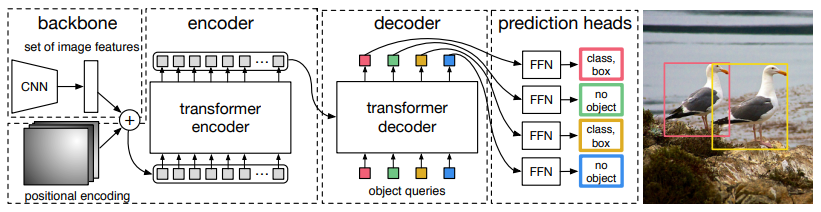

For Fully understanding DETR I recommend reading the following resources:
1. https://ai.facebook.com/blog/end-to-end-object-detection-with-transformers/
2. https://amaarora.github.io/posts/2021-07-26-annotateddetr.html

In this notebook, we will see a minimal implentation of DETR. We will then train DETR for licence plate detection problem.

---
## A minimal implementation of DETR

### Import relevant libraries

In [1]:
!pip install -q torchinfo

import torch
import torch.nn as nn
import torchvision.models as models
from torchinfo import summary

device = 'cuda' if torch.cuda.is_available() else 'cpu'

## Define a backbone network.

Note in the DETR architecture above, we first pass through a backbone CNN architecture. We will use ResNet50 pretrained model as a backbone.

In [2]:
class Backbone(nn.Module):
    def __init__(self, hidden_dim):
        super(Backbone, self).__init__()
        self.resnet = models.resnet50(pretrained=True)
        # Modify the last layer to match the required feature dimension
        in_features = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(in_features, hidden_dim)

    def forward(self, x):
        return self.resnet(x)

## Positional Encoding

Next, we design a sinusoidal positional encodding. 

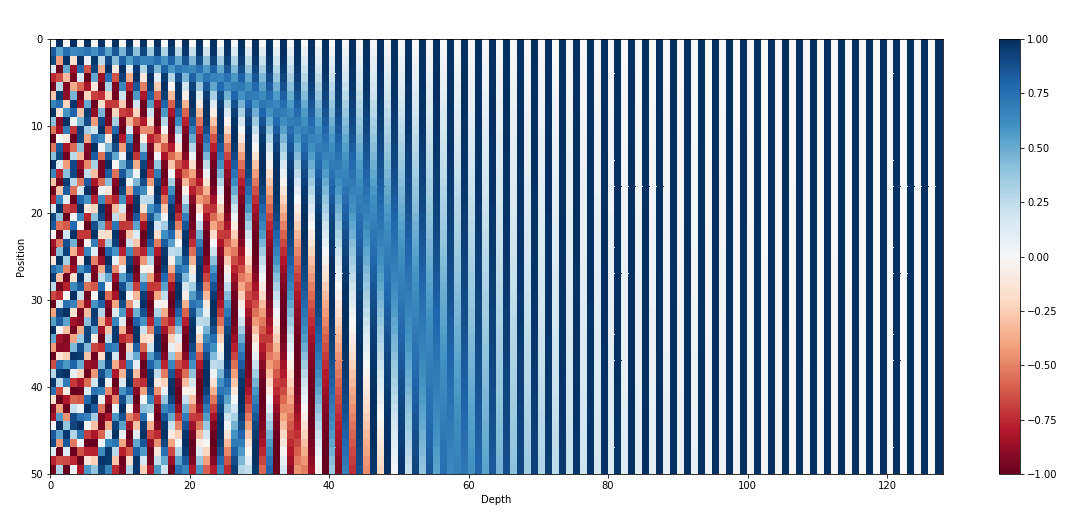

In [3]:
import math
class PositionalEncoding(nn.Module):
    def __init__(self, hidden_dim, max_len=100):
        super(PositionalEncoding, self).__init__()
        # Create a positional encoding matrix
        pe = torch.zeros(max_len, hidden_dim)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, hidden_dim, 2).float() * (-math.log(10000.0) / hidden_dim))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        return x + self.pe[:x.size(0), :]

## Detection Head

We now define the detection head. In DETR, the detection head consists of a transformer encoder block and a transformer decoder block. However, Pytorch provides us with a unified `nn.Transformer` function that encapsulates both the encoder and the decoder. In the transformer decoder, we also pass randomly initialized object queries. These object queries corresponds to the objects in the image. We initialize them randomly and hope that through training, they will be learn where the objects are located.

In [4]:
class DetectionHead(nn.Module):
    def __init__(self, hidden_dim, num_classes, num_queries):
        super(DetectionHead, self).__init__()
        self.query_embed = nn.Embedding(num_queries, hidden_dim)
        self.transformer = nn.Transformer(d_model=hidden_dim, num_encoder_layers=6, num_decoder_layers=6)
        self.linear_class = nn.Linear(hidden_dim, num_classes) #assumes background class included in num_classes
        self.linear_bbox = nn.Linear(hidden_dim, 4)

    def forward(self, x):
        query_embeds = self.query_embed.weight.unsqueeze(1).repeat(1, x.size(0), 1)
        x = self.transformer(x, query_embeds)
        class_logits = self.linear_class(x)
        bbox_preds = self.linear_bbox(x).sigmoid()
        return class_logits, bbox_preds

## DETR Architecture
Finally, we combine all the components to construct the overall architecture

In [5]:
class DETR(nn.Module):
    def __init__(self, hidden_dim, num_classes, num_queries):
        super(DETR, self).__init__()
        self.backbone = Backbone(hidden_dim)
        self.positional_encoding = PositionalEncoding(hidden_dim)
        self.detection_head = DetectionHead(hidden_dim, num_classes, num_queries)

    def forward(self, x):
        x = self.backbone(x)
        x = self.positional_encoding(x)
        class_logits, bbox_preds = self.detection_head(x)
        return {"class_logits": class_logits, "bbox_preds":bbox_preds}

## Model Visualization

In [6]:
model = DETR(hidden_dim=256, num_classes=10, num_queries=100).to(device)
summary(model, (1,3,800,1200))

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 268MB/s]


Layer (type:depth-idx)                                       Output Shape              Param #
DETR                                                         [100, 1, 4]               --
├─Backbone: 1-1                                              [1, 256]                  --
│    └─ResNet: 2-1                                           [1, 256]                  --
│    │    └─Conv2d: 3-1                                      [1, 64, 400, 600]         9,408
│    │    └─BatchNorm2d: 3-2                                 [1, 64, 400, 600]         128
│    │    └─ReLU: 3-3                                        [1, 64, 400, 600]         --
│    │    └─MaxPool2d: 3-4                                   [1, 64, 200, 300]         --
│    │    └─Sequential: 3-5                                  [1, 256, 200, 300]        215,808
│    │    └─Sequential: 3-6                                  [1, 512, 100, 150]        1,219,584
│    │    └─Sequential: 3-7                                  [1, 1024, 50, 75] 

----
# Training DETR for Licence Plate Detection

In this notebook, we will be training DETR for licence plate detection.

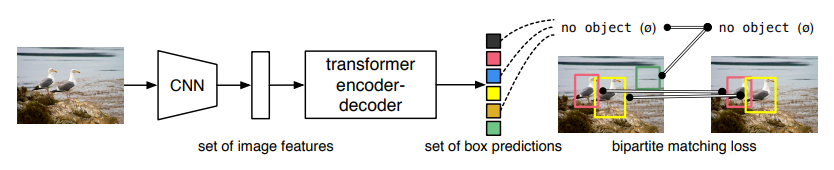

## Setup environment

In [7]:
!pip install -q timm pycocotools scipy
!pip install -qU pytorch-lightning transformers

## Download + preprocess data

Here we download the license plates dataset hosted on kaggle (in YOLOv4 format) and convert it to COCO Object Detection Format. We can use fiftyone's converter tool for that. This preprocessed dataset is available on Kaggle as COCO Licence Plate Preview (`coco_lp_preview`).

For the sake of demo we're only gonna use 20 images from that dataset.

In [8]:
!cd ../input/coco-lp-preview/coco_lp/ && ls

desktop.ini  train  val


## Create PyTorch dataset + dataloaders

Here we define a regular PyTorch dataset. Each item of the dataset is an image and corresponding annotations. Torchvision already provides a CocoDetection dataset, which we can use. We only add a feature extractor (DetrFeatureExtractor) to resize + normalize the images, and to turn the annotations (which are in COCO format) in the format that DETR expects. It will also resize the annotations accordingly.


In [9]:
import torchvision
import os

class CocoDetection(torchvision.datasets.CocoDetection):
    def __init__(self, img_folder, feature_extractor, train=True):
        ann_file = os.path.join(img_folder, "custom_train.json" if train else "custom_val.json")
        super(CocoDetection, self).__init__(img_folder, ann_file)
        self.feature_extractor = feature_extractor

    def __getitem__(self, idx):
        # read in PIL image and target in COCO format
        img, target = super(CocoDetection, self).__getitem__(idx)
        
        # preprocess image and target (converting target to DETR format, resizing + normalization of both image and target)
        image_id = self.ids[idx]
        target = {'image_id': image_id, 'annotations': target}
        encoding = self.feature_extractor(images=img, annotations=target, return_tensors="pt")
        pixel_values = encoding["pixel_values"].squeeze() # remove batch dimension
        target = encoding["labels"][0] # remove batch dimension

        return pixel_values, target

Based on the class defined above, we create training and validation datasets.

In [10]:
from transformers import DetrFeatureExtractor

img_folder = "../input/coco-lp-preview/coco_lp"

feature_extractor = DetrFeatureExtractor.from_pretrained("facebook/detr-resnet-50")

train_dataset = CocoDetection(img_folder=f'{img_folder}/train', feature_extractor=feature_extractor)
val_dataset = CocoDetection(img_folder=f'{img_folder}/val', feature_extractor=feature_extractor, train=False)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

/opt/conda/lib/python3.10/site-packages/transformers/models/detr/feature_extraction_detr.py:28: FutureWarning: The class DetrFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use DetrImageProcessor instead.
  warnings.warn(
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.


loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


As you can see, this dataset is tiny:

In [11]:
print("Number of training examples:", len(train_dataset))
print("Number of validation examples:", len(val_dataset))

Number of training examples: 20
Number of validation examples: 5


Let's verify an example by visualizing it. We can access the COCO API of the dataset by typing `train_dataset.coco`.

Image n°5


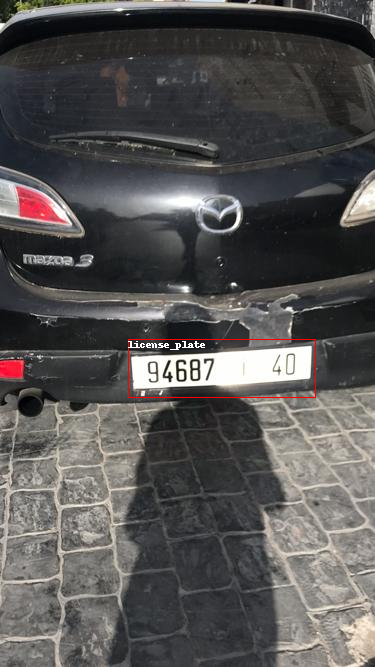

In [12]:
import numpy as np
import os
from PIL import Image, ImageDraw

# based on https://github.com/woctezuma/finetune-detr/blob/master/finetune_detr.ipynb
image_ids = train_dataset.coco.getImgIds()
# let's pick a random image
image_id = image_ids[np.random.randint(0, len(image_ids))]
print('Image n°{}'.format(image_id))
image = train_dataset.coco.loadImgs(image_id)[0]
image = Image.open(os.path.join(f'{img_folder}/train', image['file_name']))

annotations = train_dataset.coco.imgToAnns[image_id]
draw = ImageDraw.Draw(image, "RGBA")

cats = train_dataset.coco.cats
id2label = {k: v['name'] for k,v in cats.items()}

for annotation in annotations:
  box = annotation['bbox']
  class_idx = annotation['category_id']
  x,y,w,h = tuple(box)
  draw.rectangle((x,y,x+w,y+h), outline='red', width=1)
  draw.text((x, y), id2label[class_idx], fill='white')

image

Next, let's create corresponding dataloaders. We define a custom collate_fn to batch images together. As DETR resizes images to have a min size of 800 and a max size of 1333, images can have different sizes. We pad images (pixel_values) to the largest image in a batch, and create a corresponding pixel_mask to indicate which pixels are real (1)/which are padding (0).

In [13]:
from torch.utils.data import DataLoader

def collate_fn(batch):
  pixel_values = [item[0] for item in batch]
  encoding = feature_extractor.pad_and_create_pixel_mask(pixel_values, return_tensors="pt")
  labels = [item[1] for item in batch]
  batch = {}
  batch['pixel_values'] = encoding['pixel_values']
  batch['pixel_mask'] = encoding['pixel_mask']
  batch['labels'] = labels
  return batch

train_dataloader = DataLoader(train_dataset, collate_fn=collate_fn, batch_size=4, shuffle=True)
val_dataloader = DataLoader(val_dataset, collate_fn=collate_fn, batch_size=2)
batch = next(iter(train_dataloader))

This method is deprecated and will be removed in v4.27.0. Please use pad instead.


Let's verify the keys of a single batch:

In [14]:
batch.keys()

dict_keys(['pixel_values', 'pixel_mask', 'labels'])

In [15]:
pixel_values, target = train_dataset[0]

Let's verify the shape of the `pixel_values`, and check the `target`:

In [16]:
pixel_values.shape

torch.Size([3, 1333, 750])

In [17]:
print(target)

{'size': tensor([1333,  750]), 'image_id': tensor([1]), 'class_labels': tensor([0]), 'boxes': tensor([[0.8667, 0.5578, 0.2250, 0.1047]]), 'area': tensor([23548.9121]), 'iscrowd': tensor([0]), 'orig_size': tensor([1280,  720])}


## Model Training
Here we use PyTorch Lightning module to train the netwok. Here we define a LightningModule, which is an nn.Module with some extra functionality.

For more information regarding PyTorch Lightning, I recommend the [docs](https://pytorch-lightning.readthedocs.io/en/latest/?_ga=2.35105442.2002381006.1623231889-1738348008.1615553774) as well as the [tutorial notebooks](https://github.com/PyTorchLightning/lightning-tutorials/tree/aeae8085b48339e9bd9ab61d81cc0dc8b0d48f9c/.notebooks/starters).

You can of course just train the model in native PyTorch as an alternative.

In [18]:
import pytorch_lightning as pl
from transformers import DetrConfig, DetrForObjectDetection
import torch

class Detr(pl.LightningModule):

     def __init__(self, lr, lr_backbone, weight_decay):
         super().__init__()
         # replace COCO classification head with custom head
         self.model = DetrForObjectDetection.from_pretrained("facebook/detr-resnet-50", 
                                                             num_labels=len(id2label),
                                                             ignore_mismatched_sizes=True)
         # see https://github.com/PyTorchLightning/pytorch-lightning/pull/1896
         self.lr = lr
         self.lr_backbone = lr_backbone
         self.weight_decay = weight_decay

     def forward(self, pixel_values, pixel_mask):
       outputs = self.model(pixel_values=pixel_values, pixel_mask=pixel_mask)

       return outputs
     
     def common_step(self, batch, batch_idx):
       pixel_values = batch["pixel_values"]
       pixel_mask = batch["pixel_mask"]
       labels = [{k: v.to(self.device) for k, v in t.items()} for t in batch["labels"]]

       outputs = self.model(pixel_values=pixel_values, pixel_mask=pixel_mask, labels=labels)

       loss = outputs.loss
       loss_dict = outputs.loss_dict

       return loss, loss_dict

     def training_step(self, batch, batch_idx):
        loss, loss_dict = self.common_step(batch, batch_idx)     
        # logs metrics for each training_step,
        # and the average across the epoch
        self.log("training_loss", loss)
        for k,v in loss_dict.items():
          self.log("train_" + k, v.item())

        return loss

     def validation_step(self, batch, batch_idx):
        loss, loss_dict = self.common_step(batch, batch_idx)     
        self.log("validation_loss", loss)
        for k,v in loss_dict.items():
          self.log("validation_" + k, v.item())

        return loss

     def configure_optimizers(self):
        param_dicts = [
              {"params": [p for n, p in self.named_parameters() if "backbone" not in n and p.requires_grad]},
              {
                  "params": [p for n, p in self.named_parameters() if "backbone" in n and p.requires_grad],
                  "lr": self.lr_backbone,
              },
        ]
        optimizer = torch.optim.AdamW(param_dicts, lr=self.lr,
                                  weight_decay=self.weight_decay)
        
        return optimizer

     def train_dataloader(self):
        return train_dataloader

     def val_dataloader(self):
        return val_dataloader

Here we define the model, and verify the outputs.

In [19]:
model = Detr(lr=1e-4, lr_backbone=1e-5, weight_decay=1e-4)

outputs = model(pixel_values=batch['pixel_values'], pixel_mask=batch['pixel_mask'])

Some weights of DetrForObjectDetection were not initialized from the model checkpoint at facebook/detr-resnet-50 and are newly initialized because the shapes did not match:
- class_labels_classifier.weight: found shape torch.Size([92, 256]) in the checkpoint and torch.Size([2, 256]) in the model instantiated
- class_labels_classifier.bias: found shape torch.Size([92]) in the checkpoint and torch.Size([2]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


The logits are of shape `(batch_size, num_queries, number of classes + 1)`. We model internally adds an additional "no object class", which explains why we have one additional output for the class dimension.

In [20]:
outputs.logits.shape

torch.Size([4, 100, 2])

Next, let's train! We train for a maximum of 300 training steps, and also use gradient clipping. 

In [21]:
from pytorch_lightning import Trainer
from tqdm.notebook import tqdm

trainer = Trainer(max_steps=300, gradient_clip_val=0.1, accelerator="auto")
trainer.fit(model)

Sanity Checking: 0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/pytorch_lightning/utilities/data.py:76: UserWarning: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 2. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
  warning_cache.warn(
/opt/conda/lib/python3.10/site-packages/pytorch_lightning/loops/fit_loop.py:280: PossibleUserWarning: The number of training batches (5) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/pytorch_lightning/utilities/data.py:76: UserWarning: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 1. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
  warning_cache.warn(


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

## Inference (+ visualization)

Let's visualize the predictions of DETR on the first image of the validation set.


In [22]:
import torch
import matplotlib.pyplot as plt

# colors for visualization
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]

# for output bounding box post-processing
def box_cxcywh_to_xyxy(x):
    x_c, y_c, w, h = x.unbind(1)
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h),
         (x_c + 0.5 * w), (y_c + 0.5 * h)]
    return torch.stack(b, dim=1)

def rescale_bboxes(out_bbox, size):
    img_w, img_h = size
    b = box_cxcywh_to_xyxy(out_bbox)
    b = b * torch.tensor([img_w, img_h, img_w, img_h], dtype=torch.float32)
    return b

def plot_results(pil_img, prob, boxes):
    plt.figure(figsize=(16,10))
    plt.imshow(pil_img)
    ax = plt.gca()
    colors = COLORS * 100
    for p, (xmin, ymin, xmax, ymax), c in zip(prob, boxes.tolist(), colors):
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                   fill=False, color=c, linewidth=3))
        cl = p.argmax()
        text = f'{id2label[cl.item()]}: {p[cl]:0.2f}'
        ax.text(xmin, ymin, text, fontsize=15,
                bbox=dict(facecolor='yellow', alpha=0.5))
    plt.axis('off')
    plt.show()

In [23]:
def visualize_predictions(image, outputs, threshold=0.9, keep_highest_scoring_bbox=False):
  # keep only predictions with confidence >= threshold
  probas = outputs.logits.softmax(-1)[0, :, :-1]
  keep = probas.max(-1).values > threshold
  if keep_highest_scoring_bbox:
    keep = probas.max(-1).values.argmax()
    keep = torch.tensor([keep])
  
  # convert predicted boxes from [0; 1] to image scales
  bboxes_scaled = rescale_bboxes(outputs.pred_boxes[0, keep].cpu(), image.size)
    
  # plot results
  plot_results(image, probas[keep], bboxes_scaled)

In [24]:
it = iter(range(1500))

torch.Size([1, 3, 1332, 749])


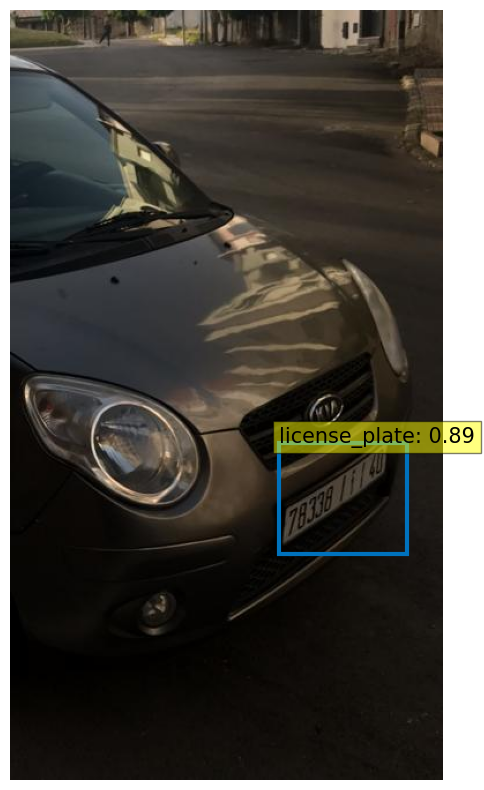

In [25]:
#We can use the image_id in target to know which image it is
pixel_values, target = val_dataset[next(it)]

pixel_values = pixel_values.unsqueeze(0).to(device)
print(pixel_values.shape)

# forward pass to get class logits and bounding boxes
model.to(device)
model.eval()
outputs = model(pixel_values=pixel_values, pixel_mask=None)

image_id = target['image_id'].item()
image = val_dataset.coco.loadImgs(image_id)[0]
image = Image.open(os.path.join(f'{img_folder}/val', image['file_name']))

visualize_predictions(image, outputs, threshold=0.3, keep_highest_scoring_bbox=True)

---
# Useful Resources for object detection:
1. https://github.com/facebookresearch/detectron2
2. https://github.com/IDEA-Research/detrex
3. https://github.com/open-mmlab/mmdetection